#LSTM and ARIMA with Parabolic SAR technical indicator


**Students:** Gabriel Sposito and Thomas Frentzel

**LSTM**


In [1]:
!pip install ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=12b6fde9806d7e89750caadbe0011053005c51af1aa175e339766b569d27ca53
  Stored in directory: /root/.cache/pip/wheels/5f/67/4f/8a9f252836e053e532c6587a3230bc72a4deb16b03a829610b
Successfully built ta


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dropout, LSTM, Dense
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from ta.trend import CCIIndicator, MACD
from ta.momentum import RSIIndicator
from ta.volatility import BollingerBands
from ta.trend import PSARIndicator

In [3]:
base = pd.read_csv('AMD 5Y.csv')
base.head()

,Date,Close/Last,Volume,Open,High,Low
0,10/08/2024,$172.80,34730150,$171.75,$173.60,$170.00
1,10/07/2024,$170.97,38379930,$171.08,$172.41,$168.21
2,10/04/2024,$170.90,44640300,$166.533,$171.21,$164.42
3,10/03/2024,$162.85,29598790,$159.71,$166.7894,$159.40
4,10/02/2024,$159.78,24630430,$159.31,$163.10,$158.6689


In [4]:
# Removing nule results
base.dropna()

,Date,Close/Last,Volume,Open,High,Low
0,10/08/2024,$172.80,34730150,$171.75,$173.60,$170.00
1,10/07/2024,$170.97,38379930,$171.08,$172.41,$168.21
2,10/04/2024,$170.90,44640300,$166.533,$171.21,$164.42
3,10/03/2024,$162.85,29598790,$159.71,$166.7894,$159.40
4,10/02/2024,$159.78,24630430,$159.31,$163.10,$158.6689
...,...,...,...,...,...,...
1253,10/15/2019,$30.72,42142390,$30.70,$30.92,$30.17
1254,10/14/2019,$30.53,44818230,$29.71,$30.61,$29.38
1255,10/11/2019,$29.75,66632450,$28.83,$30.20,$28.81
1256,10/10/2019,$28.38,41172000,$28.52,$28.89,$28.00


In [5]:
# Removing $
base['Close/Last'] = base['Close/Last'].str.replace('$', '')
base['Open'] = base['Open'].str.replace('$', '')
base['High'] = base['High'].str.replace('$', '')
base['Low'] = base['Low'].str.replace('$', '')

# Converting str to float
base['Close/Last'] = base['Close/Last'].astype(float)
base['Open'] = base['Open'].astype(float)
base['High'] = base['High'].astype(float)
base['Low'] = base['Low'].astype(float)

In [6]:
cci = CCIIndicator(high=base['High'], low=base['Low'], close=base['Close/Last'], window=20, constant=0.015)
base['CCI'] = cci.cci()

sma_tp = base['High'] + base['Low'] + base['Close/Last'] / 3
sma_tp = sma_tp.rolling(window=20).mean()
mean_deviation = np.mean(np.abs(base['Close/Last'] - sma_tp))

rsi = RSIIndicator(close=base['Close/Last'], window=14)
base['RSI'] = rsi.rsi()

macd = MACD(close=base['Close/Last'], window_slow=26, window_fast=12, window_sign=9)
base['MACD'] = macd.macd()
base['MACD_Signal'] = macd.macd_signal()
base['MACD_Diff'] = macd.macd_diff()

psar = PSARIndicator(high=base['High'], low=base['Low'], close=base['Close/Last'])
base['Parabolic_SAR'] = psar.psar()

bollinger = BollingerBands(close=base['Close/Last'], window=20, window_dev=2)
base['Bollinger_High'] = bollinger.bollinger_hband()
base['Bollinger_Low'] = bollinger.bollinger_lband()
base['Bollinger_Middle'] = bollinger.bollinger_mavg()
base['Bollinger_Width'] = bollinger.bollinger_wband()

base.dropna()

,Date,Close/Last,Volume,Open,High,Low,CCI,RSI,MACD,MACD_Signal,MACD_Diff,Parabolic_SAR,Bollinger_High,Bollinger_Low,Bollinger_Middle,Bollinger_Width
33,08/21/2024,157.81,42791250,156.12,158.6500,155.07,128.490106,56.724050,-1.735664,-4.266283,2.530619,146.212562,159.538951,134.672049,147.1055,16.904128
34,08/20/2024,156.40,76851160,156.49,162.0400,154.51,120.837780,54.942210,-1.096467,-3.632320,2.535853,148.392952,160.585017,134.436983,147.5110,17.726158
35,08/19/2024,155.28,60766850,148.43,155.3650,147.72,60.194674,53.504486,-0.672520,-3.040360,2.367840,162.040000,161.173218,134.294782,147.7340,18.193805
36,08/16/2024,148.56,31123930,145.70,149.3693,145.20,2.305252,45.766121,-0.868773,-2.606043,1.737270,162.040000,160.856405,134.259595,147.5580,18.024648
37,08/15/2024,147.36,43582390,143.00,147.9600,141.81,-19.231609,44.527651,-1.108358,-2.306506,1.198148,161.366400,160.428964,134.192036,147.3105,17.810630
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1253,10/15/2019,30.72,42142390,30.70,30.9200,30.17,-99.383285,24.075332,-2.154763,-2.139259,-0.015504,31.550800,37.639676,29.249324,33.4445,25.087388
1254,10/14/2019,30.53,44818230,29.71,30.6100,29.38,-105.536352,23.449722,-2.121456,-2.135699,0.014243,31.410000,37.317478,28.993522,33.1555,25.105806
1255,10/11/2019,29.75,66632450,28.83,30.2000,28.81,-117.461809,21.033342,-2.133407,-2.135240,0.001833,31.004000,36.981669,28.675331,32.8285,25.302215
1256,10/10/2019,28.38,41172000,28.52,28.8900,28.00,-148.813340,17.602422,-2.227746,-2.153741,-0.074004,30.610000,36.699642,28.167358,32.4335,26.307012


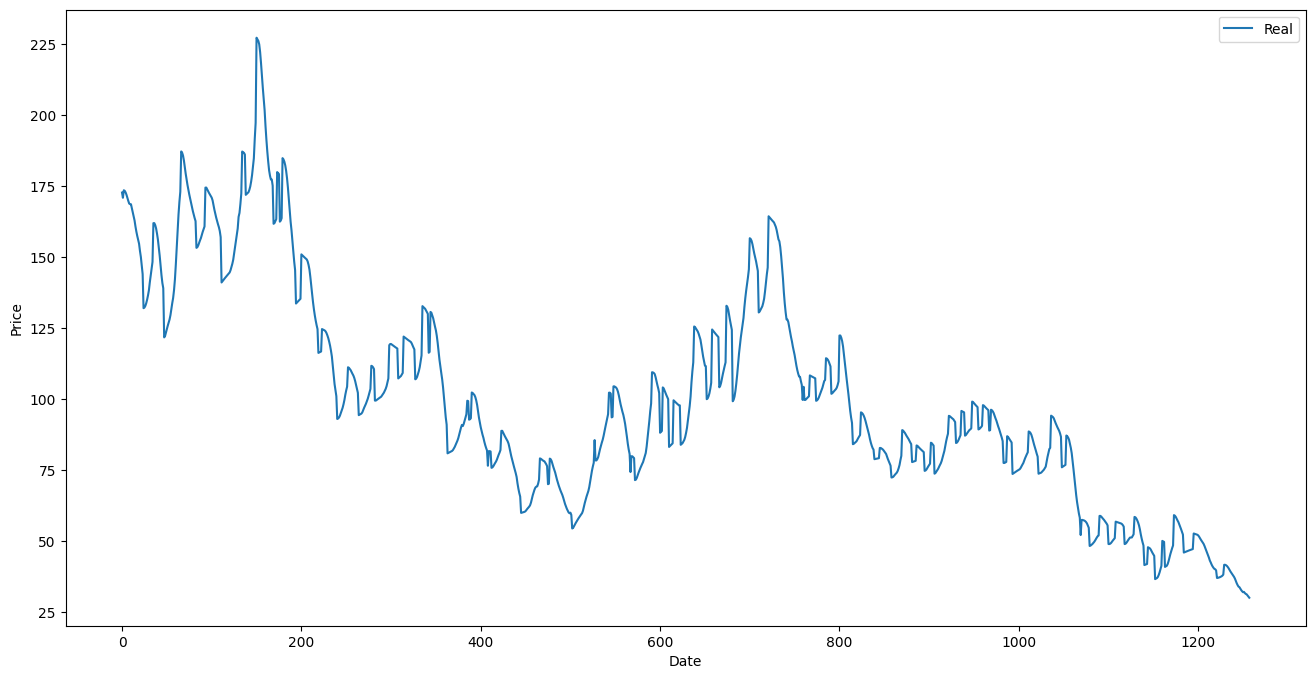

In [7]:
plt.figure(figsize=(16,8))
plt.plot(base['Parabolic_SAR'], label='Real')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

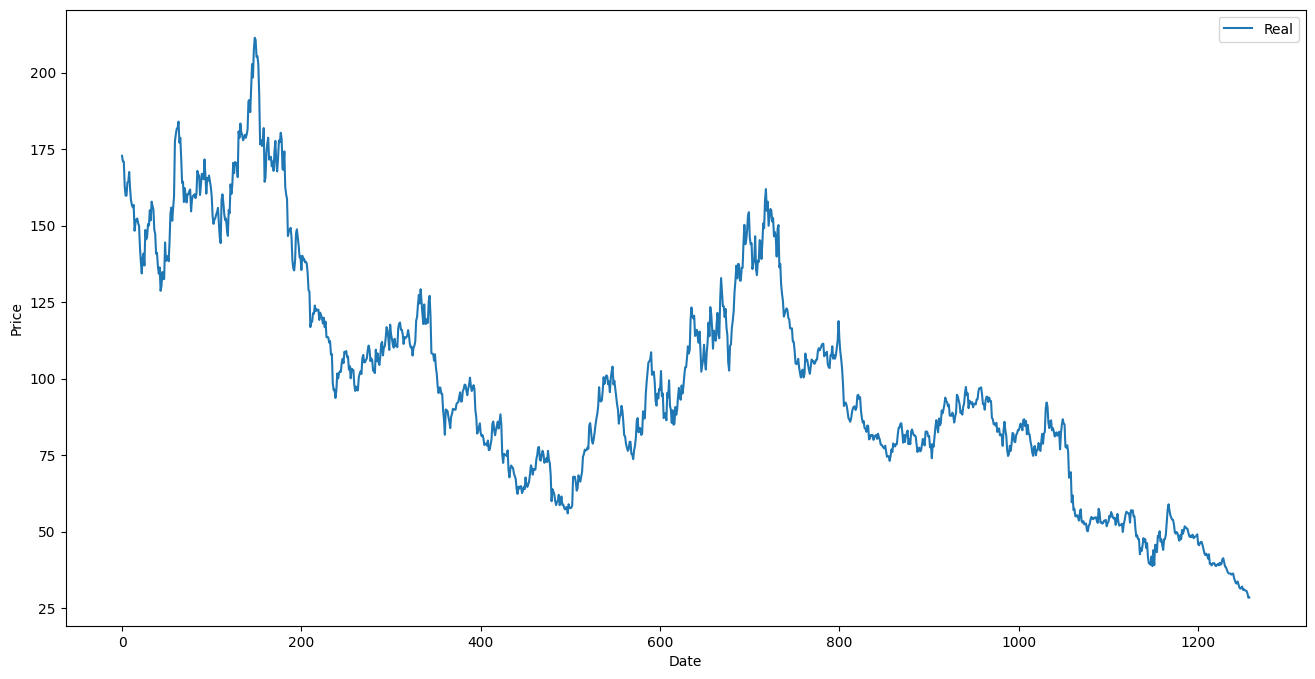

In [8]:
plt.figure(figsize=(16,8))
plt.plot(base['Close/Last'], label='Real')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

In [9]:
# Converting indicator values ​​to numeric values ​​and removing NaN values
base = base.replace([np.inf, -np.inf], np.nan)
base = base.dropna()

In [10]:
# Normalizing the data of real values
scaler_real_value = MinMaxScaler(feature_range=(0, 1))
scaled_data_real_value = scaler_real_value.fit_transform(np.array(base['Close/Last']).reshape(-1, 1))

In [11]:
window_size_real_value = 10
forecasters_real_value = []
real_value_of_prices = []
for i in range(window_size_real_value, len(base)):
    forecasters_real_value.append(scaled_data_real_value[i - window_size_real_value:i, 0])
    real_value_of_prices.append(scaled_data_real_value[i, 0])

forecasters_real_value, real_value_of_prices = np.array(forecasters_real_value), np.array(real_value_of_prices)
forecasters_real_value = np.reshape(forecasters_real_value, (forecasters_real_value.shape[0], forecasters_real_value.shape[1], 1))

In [12]:
#dividindo a coluna close/last em 70% treino e 30% teste com trai_test_split
Xtrain_real_lstm, Xtest_real_lstm, ytrain_real_lstm, ytest_real_lstm = train_test_split(forecasters_real_value, real_value_of_prices,
                                                                                        test_size = 0.3, shuffle = False)

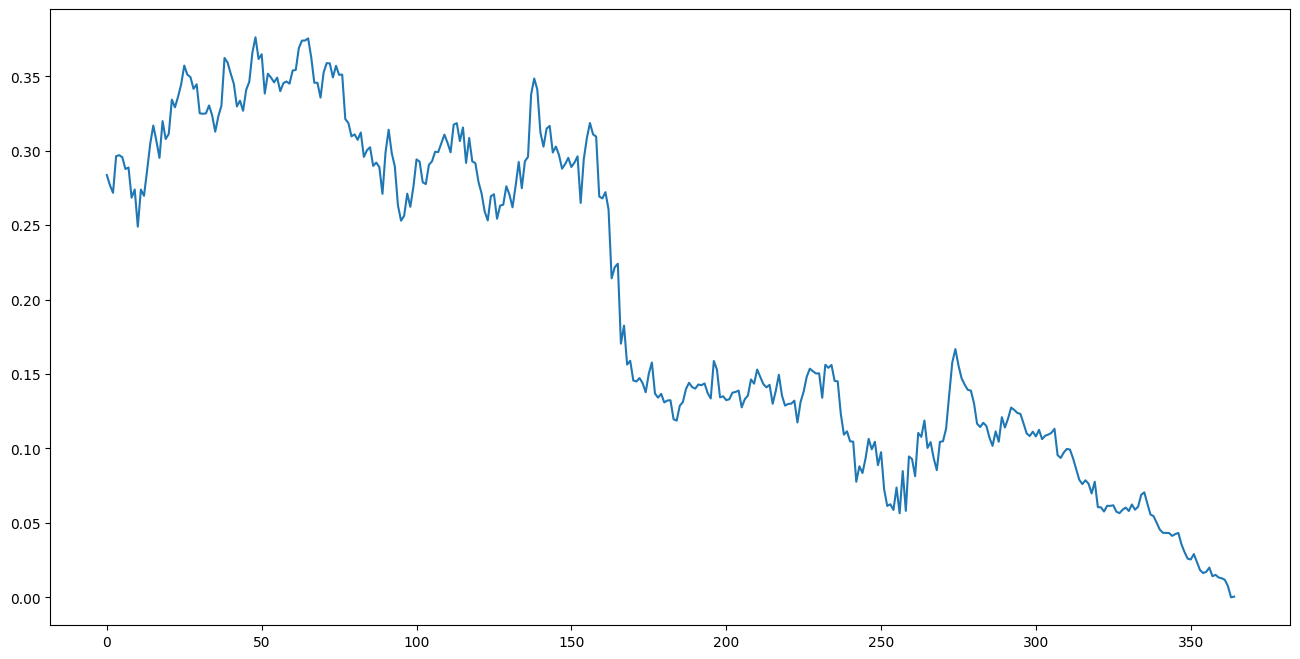

In [13]:
#plotando grafico dos valores de teste
plt.figure(figsize=(16,8))
plt.plot(ytest_real_lstm)
plt.show()

In [14]:
# Normalizing the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(np.array(base['Parabolic_SAR']).reshape(-1, 1))

In [15]:
window_size = 10
forecasters = []
real_value = []
for i in range(window_size, len(base)):
    forecasters.append(scaled_data[i - window_size:i, 0])
    real_value.append(scaled_data[i, 0])

forecasters, real_value = np.array(forecasters), np.array(real_value)
forecasters = np.reshape(forecasters, (forecasters.shape[0], forecasters.shape[1], 1))

In [16]:
# Separating data between training and testing
X_train, X_test, y_train, y_test = train_test_split(forecasters, real_value, test_size=0.3, shuffle=False)

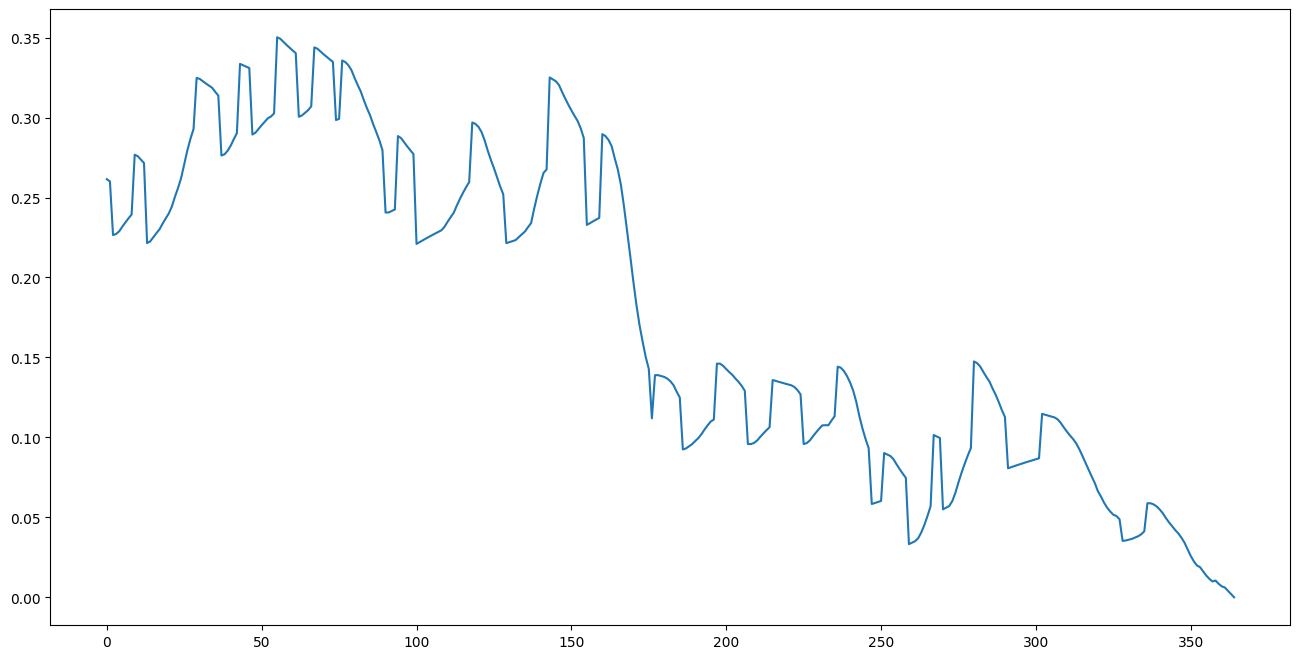

In [17]:
plt.figure(figsize=(16, 8))
plt.plot(y_test)
plt.show()

In [18]:
# LSTM model

lstm = Sequential()
lstm.add(LSTM(units=50, return_sequences=True, input_shape=(forecasters.shape[1], 1)))
lstm.add(Dropout(0.3))
lstm.add(LSTM(units=50, return_sequences=True))
lstm.add(Dropout(0.3))
lstm.add(LSTM(units=50))
lstm.add(Dropout(0.3))
lstm.add(Dense(units=1))
lstm.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [19]:
history = lstm.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 63ms/step - loss: 0.0961 - mean_absolute_error: 0.2488 - val_loss: 0.0071 - val_mean_absolute_error: 0.0701
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0116 - mean_absolute_error: 0.0832 - val_loss: 0.0097 - val_mean_absolute_error: 0.0903
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0088 - mean_absolute_error: 0.0733 - val_loss: 0.0025 - val_mean_absolute_error: 0.0428
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0084 - mean_absolute_error: 0.0699 - val_loss: 0.0016 - val_mean_absolute_error: 0.0334
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0072 - mean_absolute_error: 0.0630 - val_loss: 0.0020 - val_mean_absolute_error: 0.0381
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0066 - mean_absolute_error: 0.0613 - val_loss: 0.0022 - val_mean_absolute_error: 0.0399
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0066 - mean_absolute_error: 0.0603 - v

In [20]:
test_predictions = lstm.predict(X_test)
test_predictions = scaler.inverse_transform(test_predictions)

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step


In [21]:
# Transforming test values ​​back to original values
y_orig_test = scaler.inverse_transform(y_test.reshape(-1, 1))

#escalonando valores de teste
ytest_real_lstm = scaler_real_value.inverse_transform(ytest_real_lstm.reshape(-1, 1))

In [22]:
test_predictions = test_predictions.ravel()  # Converts to 1D
y_orig_test = y_orig_test.ravel()
ytest_real_lstm = ytest_real_lstm.ravel()

In [23]:
test_size_L = len(y_test)

high_test_L = base['High'].tail(test_size_L)
low_test_L = base['Low'].tail(test_size_L)
close_test_L = base['Close/Last'].tail(test_size_L)

In [24]:
# Inverse Parabolic SAR formula
def inverse_psar(psar_values, high, low, close):
    original_prices = []

    original_prices.append(close[0])

    for i in range(1, len(psar_values)):
        if psar_values[i] < close[i-1]:
            estimated_price = close[i-1] + (close[i-1] - psar_values[i-1])
            estimated_price = min(estimated_price, high[i])
        else:
            estimated_price = close[i-1] - (psar_values[i-1] - close[i-1])
            estimated_price = max(estimated_price, low[i])

        original_prices.append(estimated_price)

    return np.array(original_prices)

# Making sure the data is in array format
high_test_L = high_test_L.values if isinstance(high_test_L, pd.Series) else high_test_L
low_test_L = low_test_L.values if isinstance(low_test_L, pd.Series) else low_test_L
close_test_L = close_test_L.values if isinstance(close_test_L, pd.Series) else close_test_L


In [25]:
# Inverting the values ​​test_predictions and y_orig_teste by the inverse Parabolic SAR formula
test_predictions_inverted = inverse_psar(test_predictions, high_test_L, low_test_L, close_test_L)
y_orig_test_inverted = inverse_psar(y_orig_test, high_test_L, low_test_L, close_test_L)

min_length = min(len(ytest_real_lstm), len(test_predictions_inverted))
ytest_real_lstm = ytest_real_lstm[:min_length]
test_predictions_inverted = test_predictions_inverted[:min_length]

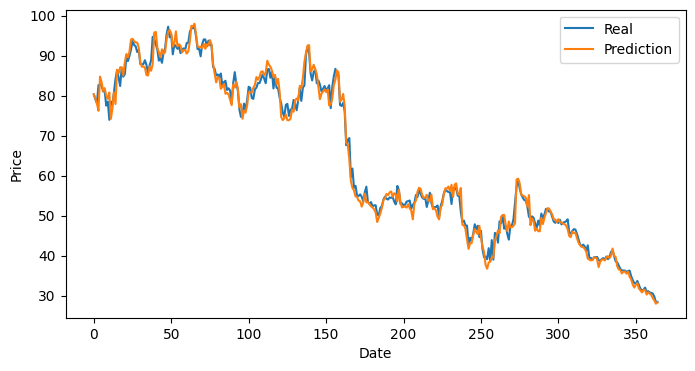

In [26]:
plt.figure(figsize=(8, 4))
plt.plot(range(len(ytest_real_lstm)), ytest_real_lstm, label='Real')
plt.plot(range(len(test_predictions_inverted)), test_predictions_inverted, label='Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [27]:
# R2 Score
r2 = r2_score(ytest_real_lstm, test_predictions_inverted)
print(f'R2 Score: {r2}')

# RMSE
rmse = np.sqrt(np.mean((ytest_real_lstm - test_predictions_inverted) ** 2))
print(f'RMSE: {rmse}')

R2 Score: 0.9915174694643826
RMSE: 1.8479738636113718


**ARIMA**

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from ta.trend import CCIIndicator, MACD
from ta.momentum import RSIIndicator
from ta.volatility import BollingerBands
from ta.trend import PSARIndicator
from math import sqrt

In [30]:
base_A = pd.read_csv('AMD 5Y.csv')
base_A.head()

,Date,Close/Last,Volume,Open,High,Low
0,10/08/2024,$172.80,34730150,$171.75,$173.60,$170.00
1,10/07/2024,$170.97,38379930,$171.08,$172.41,$168.21
2,10/04/2024,$170.90,44640300,$166.533,$171.21,$164.42
3,10/03/2024,$162.85,29598790,$159.71,$166.7894,$159.40
4,10/02/2024,$159.78,24630430,$159.31,$163.10,$158.6689


In [31]:
base_A.dtypes

,0
Date,object
Close/Last,object
Volume,int64
Open,object
High,object
Low,object


In [32]:
# Removing $
base_A['Close/Last'] = base_A['Close/Last'].str.replace('$', '')
base_A['Open'] = base_A['Open'].str.replace('$', '')
base_A['High'] = base_A['High'].str.replace('$', '')
base_A['Low'] = base_A['Low'].str.replace('$', '')

# Converting str to float
base_A['Close/Last'] = base_A['Close/Last'].astype(float)
base_A['Open'] = base_A['Open'].astype(float)
base_A['High'] = base_A['High'].astype(float)
base_A['Low'] = base_A['Low'].astype(float)

In [33]:
cci = CCIIndicator(high=base_A['High'], low=base_A['Low'], close=base_A['Close/Last'], window=20, constant=0.015)
base_A['CCI'] = cci.cci()

sma_tp = base_A['High'] + base_A['Low'] + base_A['Close/Last'] / 3
sma_tp = sma_tp.rolling(window=20).mean()
mean_deviation = np.mean(np.abs(base_A['Close/Last'] - sma_tp))

rsi = RSIIndicator(close=base_A['Close/Last'], window=14)
base_A['RSI'] = rsi.rsi()

macd = MACD(close=base_A['Close/Last'], window_slow=26, window_fast=12, window_sign=9)
base_A['MACD'] = macd.macd()
base_A['MACD_Signal'] = macd.macd_signal()
base_A['MACD_Diff'] = macd.macd_diff()

psar = PSARIndicator(high=base_A['High'], low=base_A['Low'], close=base_A['Close/Last'])
base_A['Parabolic_SAR'] = psar.psar()

bollinger = BollingerBands(close=base_A['Close/Last'], window=20, window_dev=2)
base_A['Bollinger_High'] = bollinger.bollinger_hband()
base_A['Bollinger_Low'] = bollinger.bollinger_lband()
base_A['Bollinger_Middle'] = bollinger.bollinger_mavg()
base_A['Bollinger_Width'] = bollinger.bollinger_wband()

base_A.dropna()

,Date,Close/Last,Volume,Open,High,Low,CCI,RSI,MACD,MACD_Signal,MACD_Diff,Parabolic_SAR,Bollinger_High,Bollinger_Low,Bollinger_Middle,Bollinger_Width
33,08/21/2024,157.81,42791250,156.12,158.6500,155.07,128.490106,56.724050,-1.735664,-4.266283,2.530619,146.212562,159.538951,134.672049,147.1055,16.904128
34,08/20/2024,156.40,76851160,156.49,162.0400,154.51,120.837780,54.942210,-1.096467,-3.632320,2.535853,148.392952,160.585017,134.436983,147.5110,17.726158
35,08/19/2024,155.28,60766850,148.43,155.3650,147.72,60.194674,53.504486,-0.672520,-3.040360,2.367840,162.040000,161.173218,134.294782,147.7340,18.193805
36,08/16/2024,148.56,31123930,145.70,149.3693,145.20,2.305252,45.766121,-0.868773,-2.606043,1.737270,162.040000,160.856405,134.259595,147.5580,18.024648
37,08/15/2024,147.36,43582390,143.00,147.9600,141.81,-19.231609,44.527651,-1.108358,-2.306506,1.198148,161.366400,160.428964,134.192036,147.3105,17.810630
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1253,10/15/2019,30.72,42142390,30.70,30.9200,30.17,-99.383285,24.075332,-2.154763,-2.139259,-0.015504,31.550800,37.639676,29.249324,33.4445,25.087388
1254,10/14/2019,30.53,44818230,29.71,30.6100,29.38,-105.536352,23.449722,-2.121456,-2.135699,0.014243,31.410000,37.317478,28.993522,33.1555,25.105806
1255,10/11/2019,29.75,66632450,28.83,30.2000,28.81,-117.461809,21.033342,-2.133407,-2.135240,0.001833,31.004000,36.981669,28.675331,32.8285,25.302215
1256,10/10/2019,28.38,41172000,28.52,28.8900,28.00,-148.813340,17.602422,-2.227746,-2.153741,-0.074004,30.610000,36.699642,28.167358,32.4335,26.307012


In [34]:
# Converting indicator values ​​to numeric values ​​and removing NaN values
base_A = base_A.replace([np.inf, -np.inf], np.nan)
base_A = base_A.dropna()

In [35]:
base_A.head()

,Date,Close/Last,Volume,Open,High,Low,CCI,RSI,MACD,MACD_Signal,MACD_Diff,Parabolic_SAR,Bollinger_High,Bollinger_Low,Bollinger_Middle,Bollinger_Width
33,08/21/2024,157.81,42791250,156.12,158.6500,155.07,128.490106,56.724050,-1.735664,-4.266283,2.530619,146.212562,159.538951,134.672049,147.1055,16.904128
34,08/20/2024,156.40,76851160,156.49,162.0400,154.51,120.837780,54.942210,-1.096467,-3.632320,2.535853,148.392952,160.585017,134.436983,147.5110,17.726158
35,08/19/2024,155.28,60766850,148.43,155.3650,147.72,60.194674,53.504486,-0.672520,-3.040360,2.367840,162.040000,161.173218,134.294782,147.7340,18.193805
36,08/16/2024,148.56,31123930,145.70,149.3693,145.20,2.305252,45.766121,-0.868773,-2.606043,1.737270,162.040000,160.856405,134.259595,147.5580,18.024648
37,08/15/2024,147.36,43582390,143.00,147.9600,141.81,-19.231609,44.527651,-1.108358,-2.306506,1.198148,161.366400,160.428964,134.192036,147.3105,17.810630


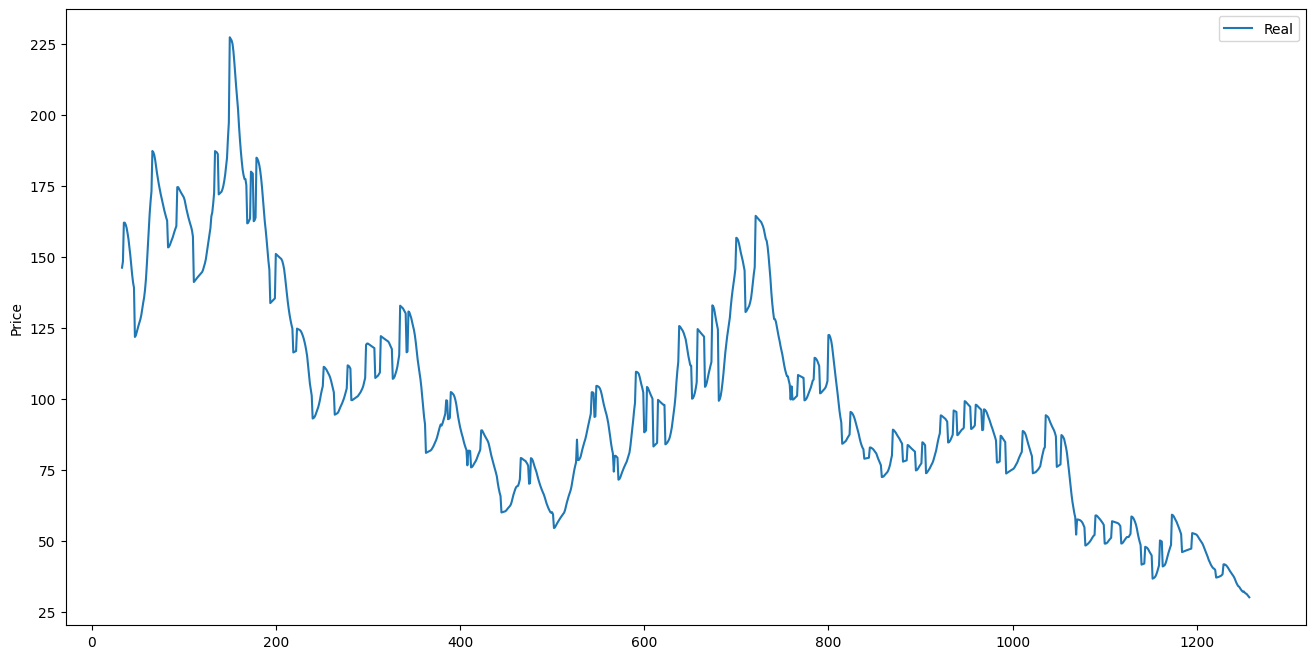

In [36]:
# Plotting Parabolic SAR
plt.figure(figsize=(16,8))
plt.plot(base_A['Parabolic_SAR'], label='Real')
plt.ylabel('Price')
plt.legend()

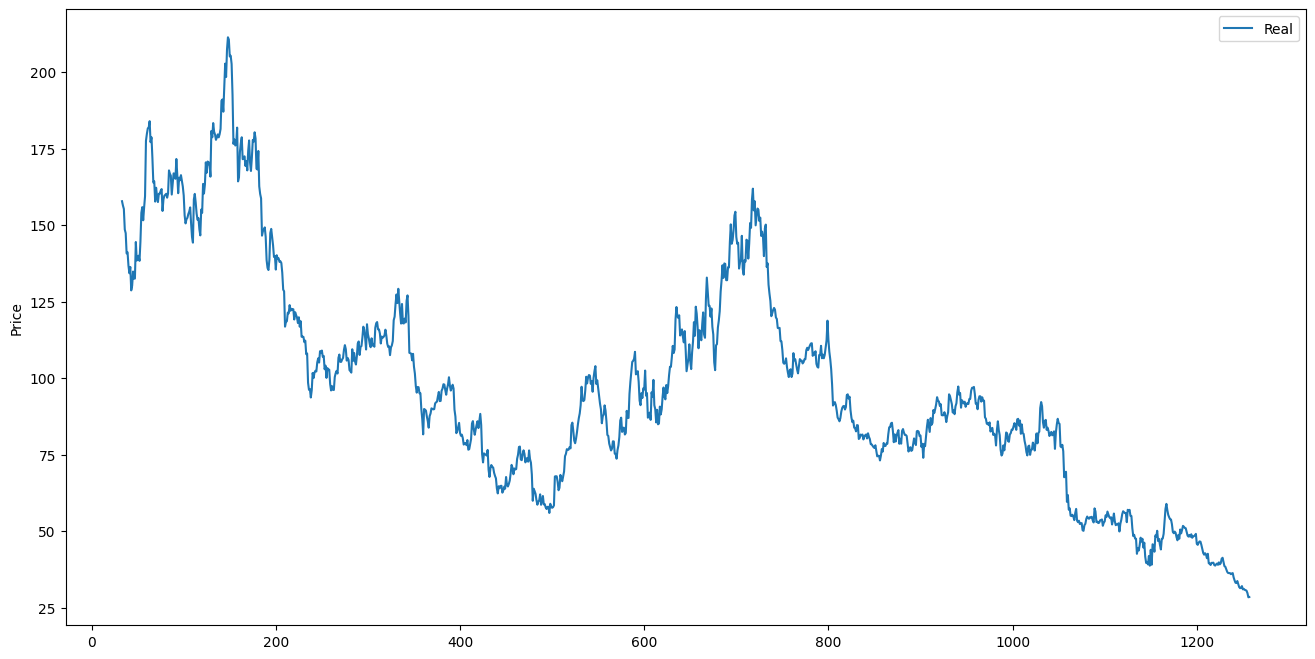

In [37]:
plt.figure(figsize=(16,8))
plt.plot(base_A['Close/Last'], label='Real')
plt.ylabel('Price')
plt.legend()

In [38]:
X_R = base_A['Close/Last'].values
size_R = int(len(X_R) * 0.70)
train_R, test_R = X_R[0:size_R], X_R[size_R:len(X_R)]
history_R = [x_r for x_r in train_R]
forecasts_R = list()

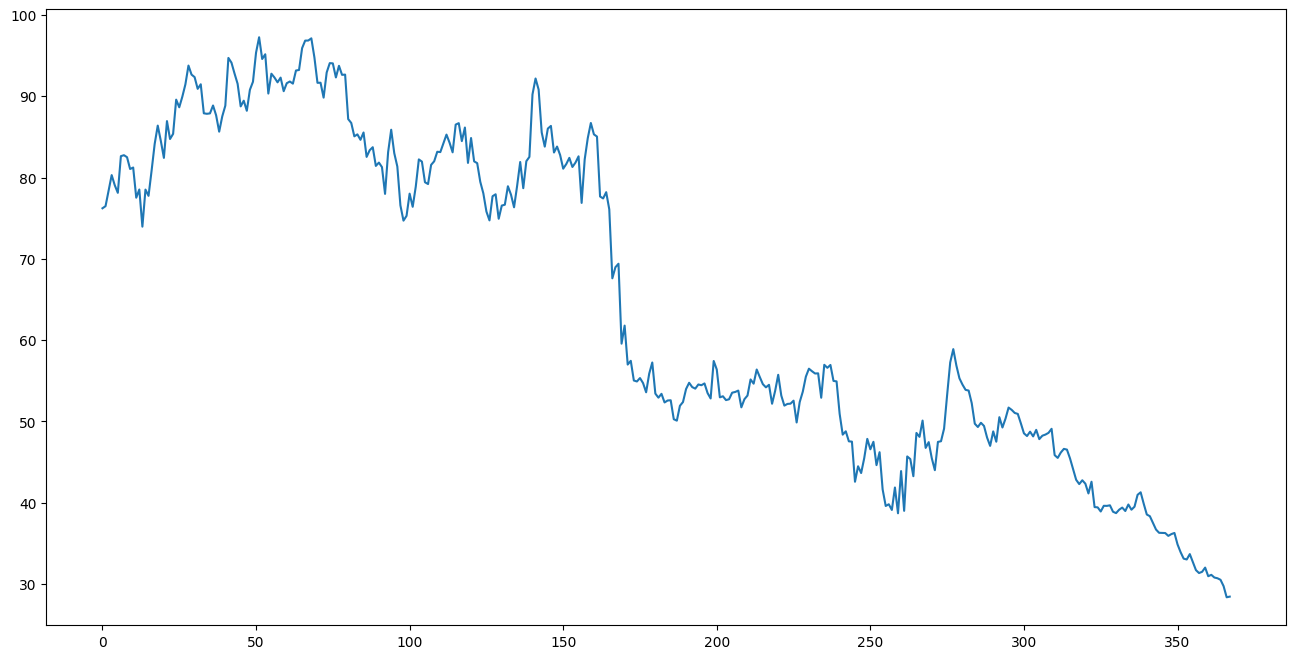

In [39]:
#Test Grafic
plt.figure(figsize=(16, 8))
plt.plot(test_R)
plt.show()

In [40]:
#Addfuller for Parabolic_SAR
result = adfuller(base_A['Parabolic_SAR'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF Statistic: -1.1513520417647416
p-value: 0.6941652482636747


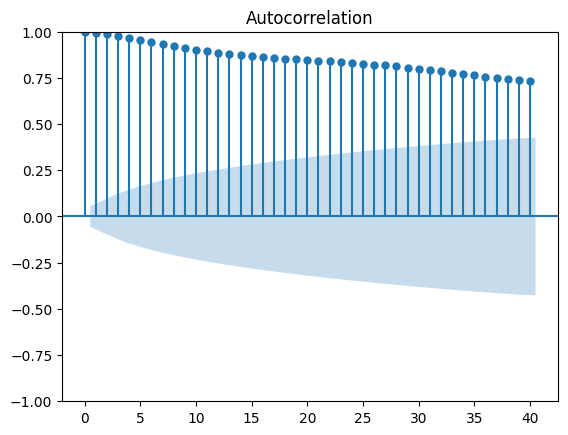

In [41]:
plot_acf(base_A['Parabolic_SAR'], lags=40)
plt.show()

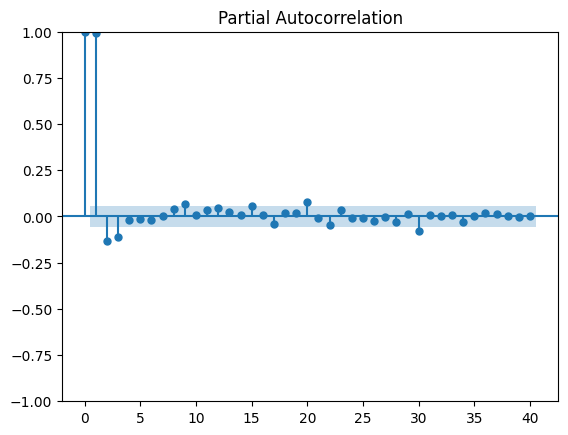

In [42]:
plot_pacf(base_A['Parabolic_SAR'], lags=40)
plt.show()

In [43]:
X = base_A['Parabolic_SAR'].values
size = int(len(X) * 0.70)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
forecasts = list()

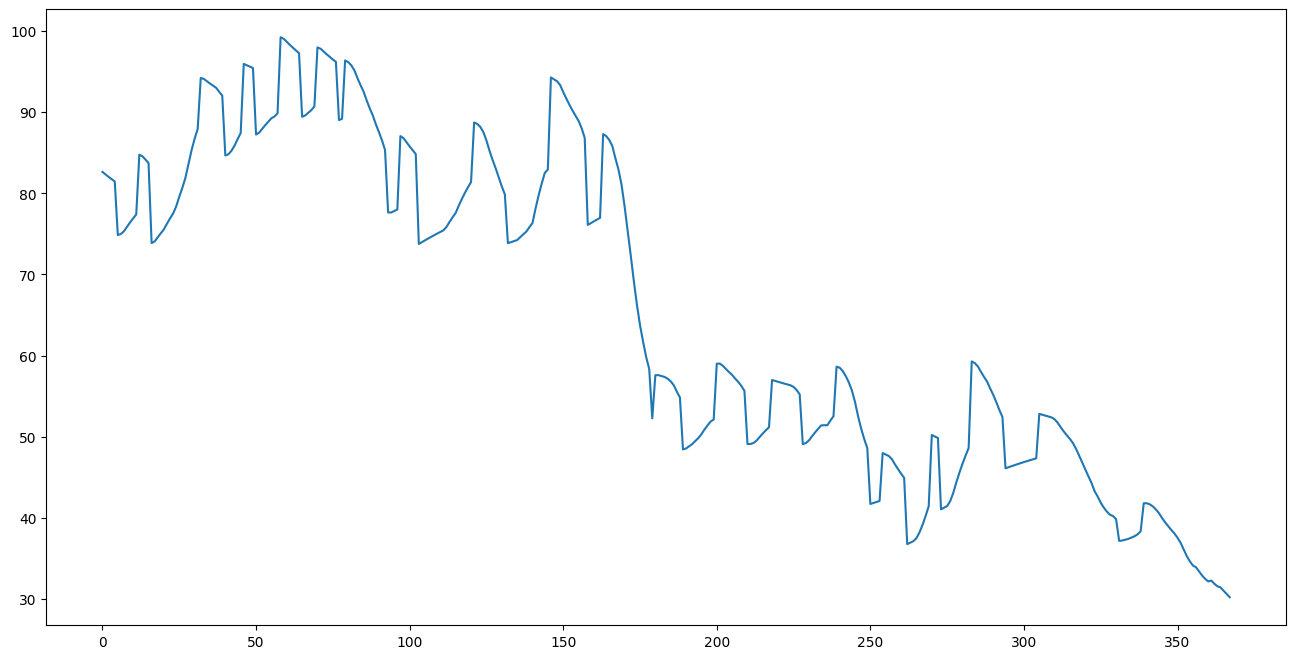

In [44]:
plt.figure(figsize=(16, 8))
plt.plot(test)
plt.show()

In [45]:
# ARIMA
for t in range(len(test)):
    model = ARIMA(history, order=(2, 1, 1))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    forecasts.append(yhat)
    obs = test[t]
    history.append(obs)
    print(f'Expected={yhat}, Observed={obs}')

Expected=82.90459372194884, Observed=82.6308992256
Expected=82.54294593201135, Observed=82.319663256576
Expected=82.2240254782166, Observed=82.02087672631296
Expected=81.9258778217453, Observed=81.73404165726045
Expected=81.64193274595199, Observed=81.45867999097003
Expected=81.36999333452243, Observed=74.85
Expected=73.71637280337194, Observed=74.9854
Expected=74.2928283018591, Observed=75.315984
Expected=75.17952321838288, Observed=75.88202496
Expected=75.95636467794667, Observed=76.41410346239999
Expected=76.556466302968, Observed=76.914257254656
Expected=77.06863383474553, Observed=77.38440181937663
Expected=77.53534842932271, Observed=84.75
Expected=86.03617732753922, Observed=84.5704
Expected=85.34384420420402, Observed=84.14198400000001
Expected=84.2826025002412, Observed=83.73070464000001
Expected=83.67762962960532, Observed=73.86
Expected=72.18907144204132, Observed=74.0704
Expected=73.03546860568393, Observed=74.58558400000001
Expected=74.41083942879284, Observed=75.080160640

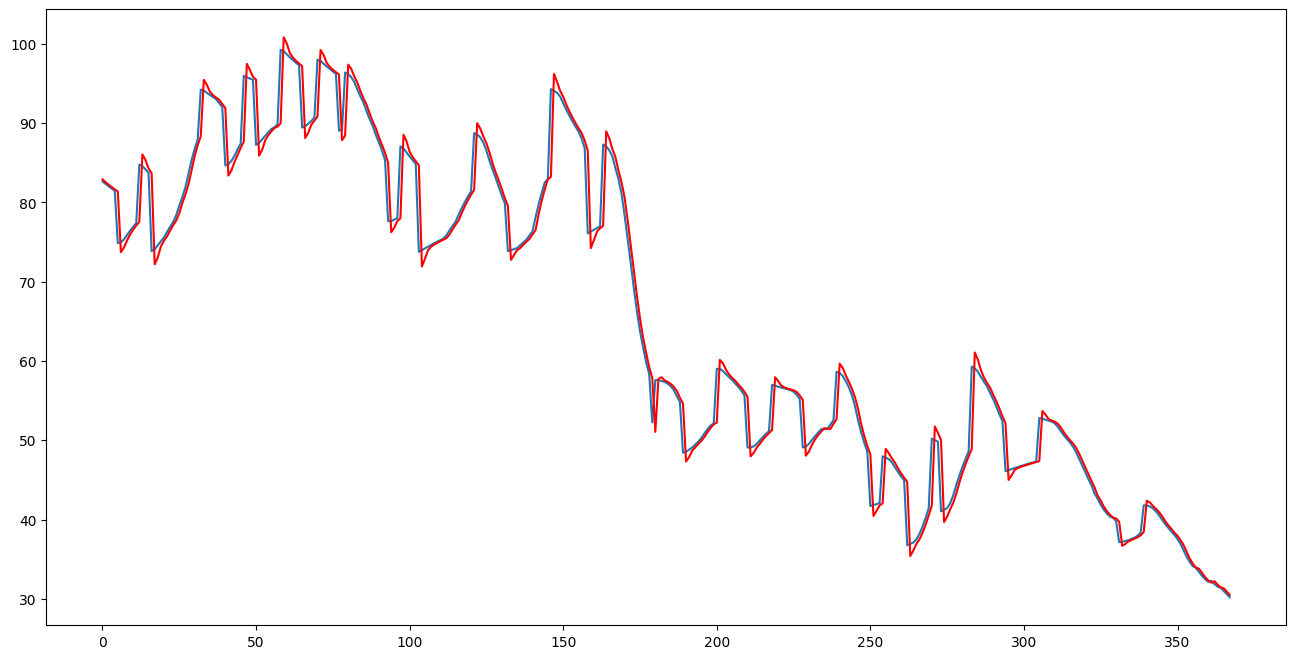

In [46]:
# Test and forecast set
plt.figure(figsize=(16, 8))
plt.plot(test)
plt.plot(forecasts, color='red')
plt.show()

In [47]:
# Ensuring that data is one-dimensional
test = test.ravel()
forecasts = np.array(forecasts).ravel()

In [48]:
# Getting the high, low and close values ​​from the test set for the Parabolic SAR
test_size_A = len(test)

high_test_A = base_A['High'].tail(test_size_A)
low_test_A = base_A['Low'].tail(test_size_A)
close_test_A = base_A['Close/Last'].tail(test_size_A)

In [49]:
print(test.shape)
print(forecasts.shape)

(368,)
(368,)


In [50]:
# Inverse Parabolic SAR formula
def inverse_psar_A(psar_values_A, high_A, low_A, close_A):
    original_prices = []

    original_prices.append(close_A[0])

    for i in range(1, len(psar_values_A)):
        if psar_values_A[i] < close_A[i-1]:
            estimated_price = close_A[i-1] + (close_A[i-1] - psar_values_A[i-1])
            estimated_price = min(estimated_price, high_A[i])
        else:
            estimated_price = close_A[i-1] - (psar_values_A[i-1] - close_A[i-1])
            estimated_price = max(estimated_price, low_A[i])

        original_prices.append(estimated_price)

    return np.array(original_prices)

# Making sure the data is in array format
high_test_A = high_test_A.values if isinstance(high_test_A, pd.Series) else high_test_A
low_test_A = low_test_A.values if isinstance(low_test_A, pd.Series) else low_test_A
close_test_A = close_test_A.values if isinstance(close_test_A, pd.Series) else close_test_A

In [51]:
test_inverted = inverse_psar_A(test, high_test_A, low_test_A, close_test_A)
forecasts_inverted = inverse_psar_A(forecasts, high_test_A, low_test_A, close_test_A)

min_length_R = min(len(test_R), len(forecasts_inverted))
test_R = test_R[:min_length_R]
forecasts_inverted = forecasts_inverted[:min_length_R]

In [52]:
# RMSE
rmse = sqrt(mean_squared_error(test_R, forecasts_inverted))
print(f'RMSE: {rmse}')

# R2 Score
r2 = r2_score(test_R, forecasts_inverted)
print(f'R2 Score: {r2}')

RMSE: 2.093288308885551
R2 Score: 0.9890621007221454


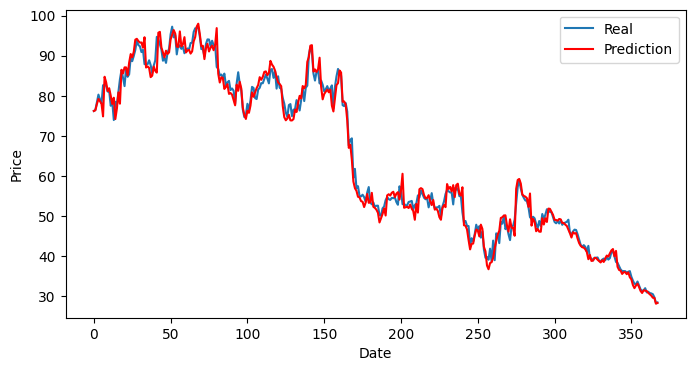

In [54]:
plt.figure(figsize=(8, 4))
plt.plot(range(len(test_R)), test_R, label='Real')
plt.plot(range(len(forecasts_inverted)), forecasts_inverted, label='Prediction', color = 'red')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()